### This notebook is copy of `fastMRI_tutorial.ipynb` notebook.

In first part it loads unprocessed data, then it loads data on which models were run.

## Raw data

In [46]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [47]:
file_name = '/media/drazen/HDD/PC/Faks/Diplomski/Prva/OSIRV/Projekt/datasets/multicoil_test/file_brain_AXT2_201_2010573.h5'
hf = h5py.File(file_name)

In [48]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 4, 'acquisition': 'AXT2', 'num_low_frequency': 32, 'patient_id': '6aea75081c891adc8355392bc2aabf777b2b02a253eb173eb4fbcfb33730fcbc'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [49]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 20, 768, 396)


In [50]:
slice_kspace = volume_kspace[10] # Choosing the 15-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [51]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

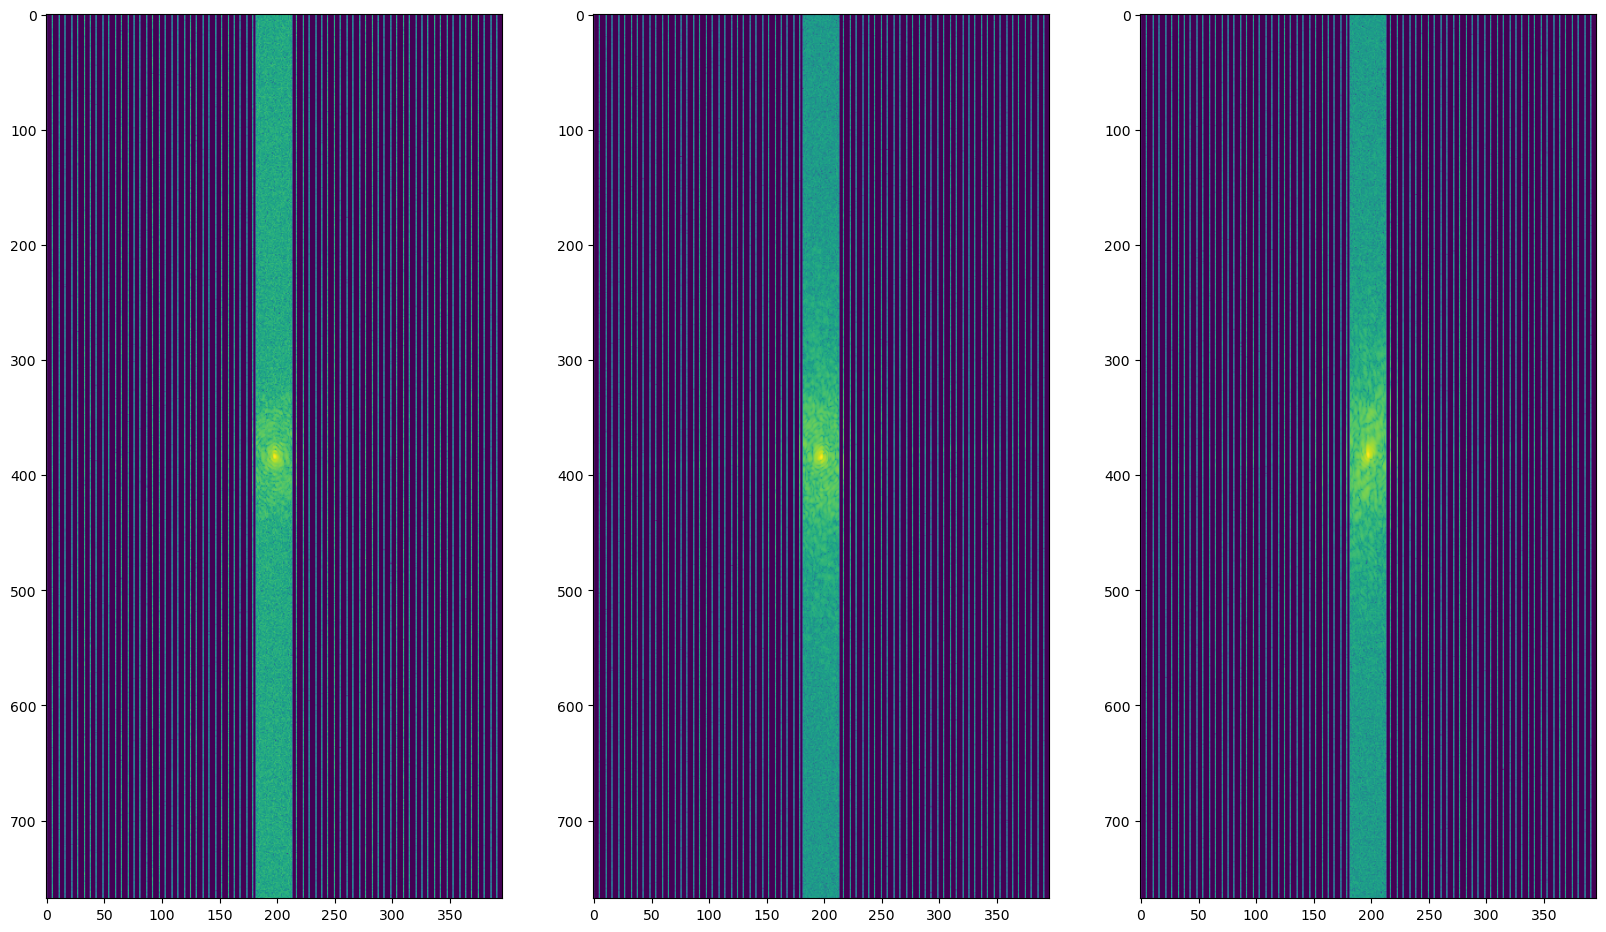

In [52]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [53]:
import fastmri
from fastmri.data import transforms as T

In [54]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

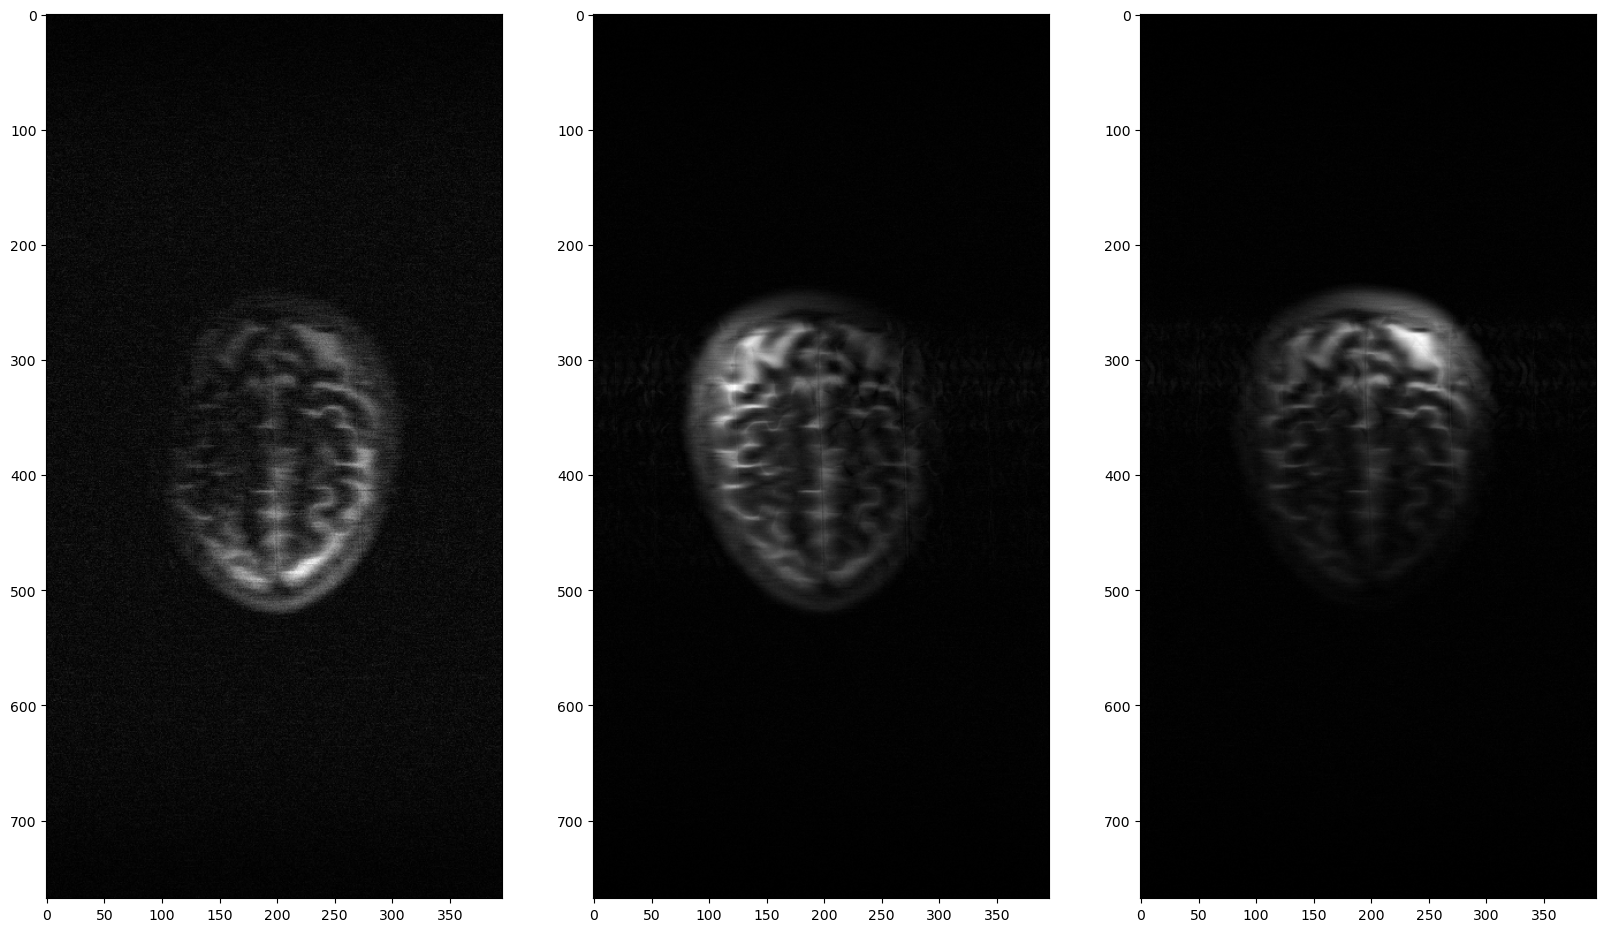

In [55]:
plt.rcParams['figure.figsize'] = [20, 16] # enlarge inline plots

show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [56]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

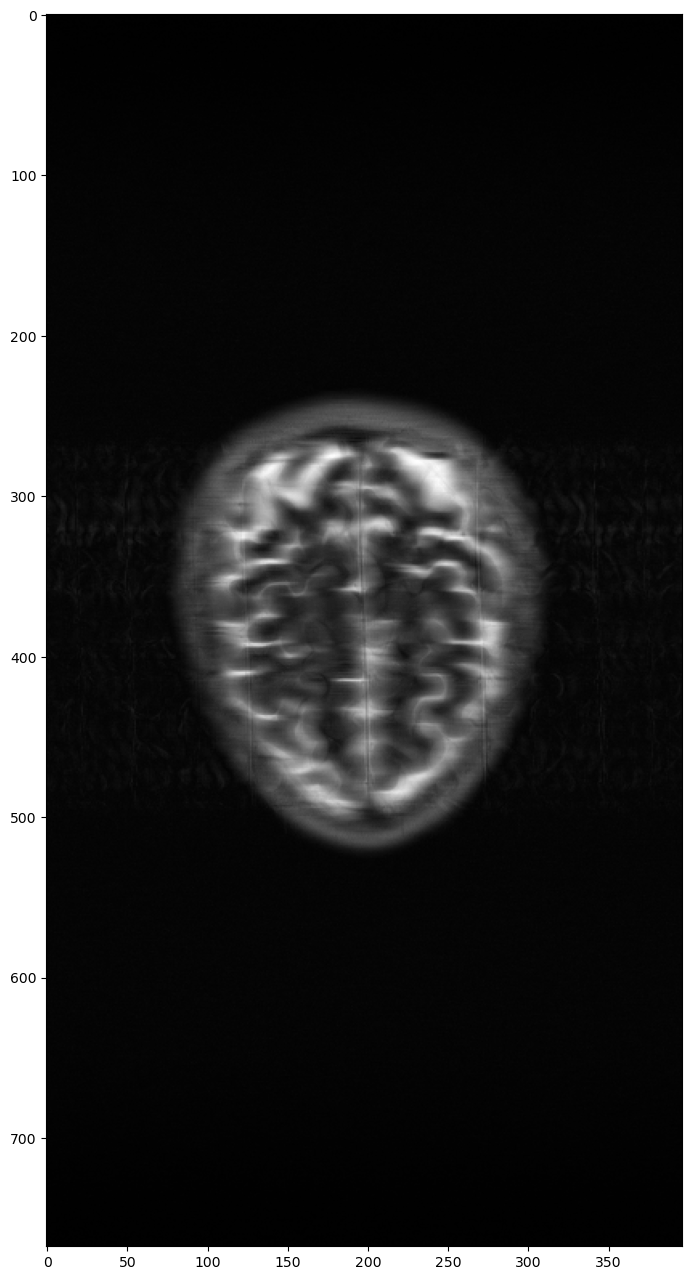

In [57]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [58]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [59]:
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [60]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

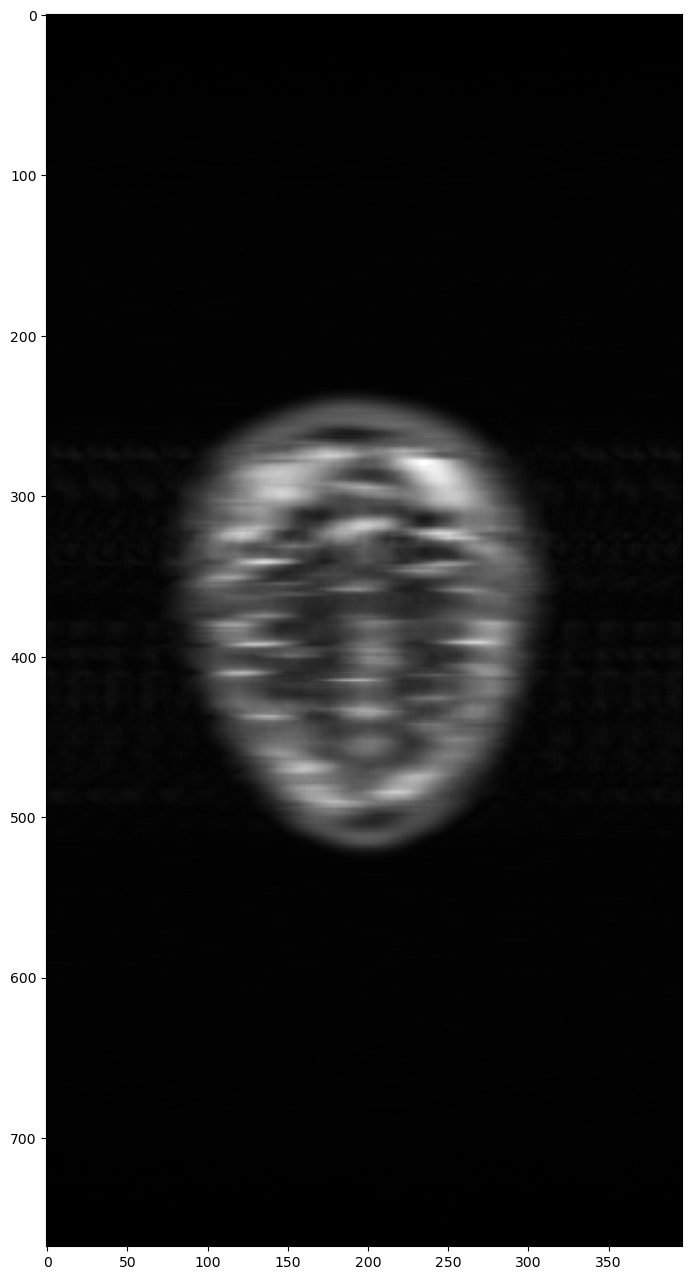

In [61]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

## Varnet

In [62]:
file_name = '/media/drazen/HDD/PC/Faks/Diplomski/Prva/OSIRV/Projekt/datasets/out_varnet/reconstructions/file_brain_AXT2_201_2010573.h5'
hf = h5py.File(file_name)

In [63]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['reconstruction']
Attrs: {}


We don't have `kspace` key anymore, now we have to use `reconstruction` key.

`Reconstruction` volume has the following shape: (number of slices, height, width).

In [64]:
volume_reconstruction = hf['reconstruction'][()]
print(volume_reconstruction.dtype)
print(volume_reconstruction.shape)

float32
(16, 384, 384)


In [81]:
slice_reconstruction = volume_reconstruction[10] # Choosing the 10th slice
print(slice_reconstruction.shape)

(384, 384)


In [113]:
def show_slices(data, num_slices, cmap=None):
    fig = plt.figure()
    for i in range(0, num_slices):
        plt.subplot(3, 5, i + 1)
        plt.imshow(data[i], cmap=cmap)

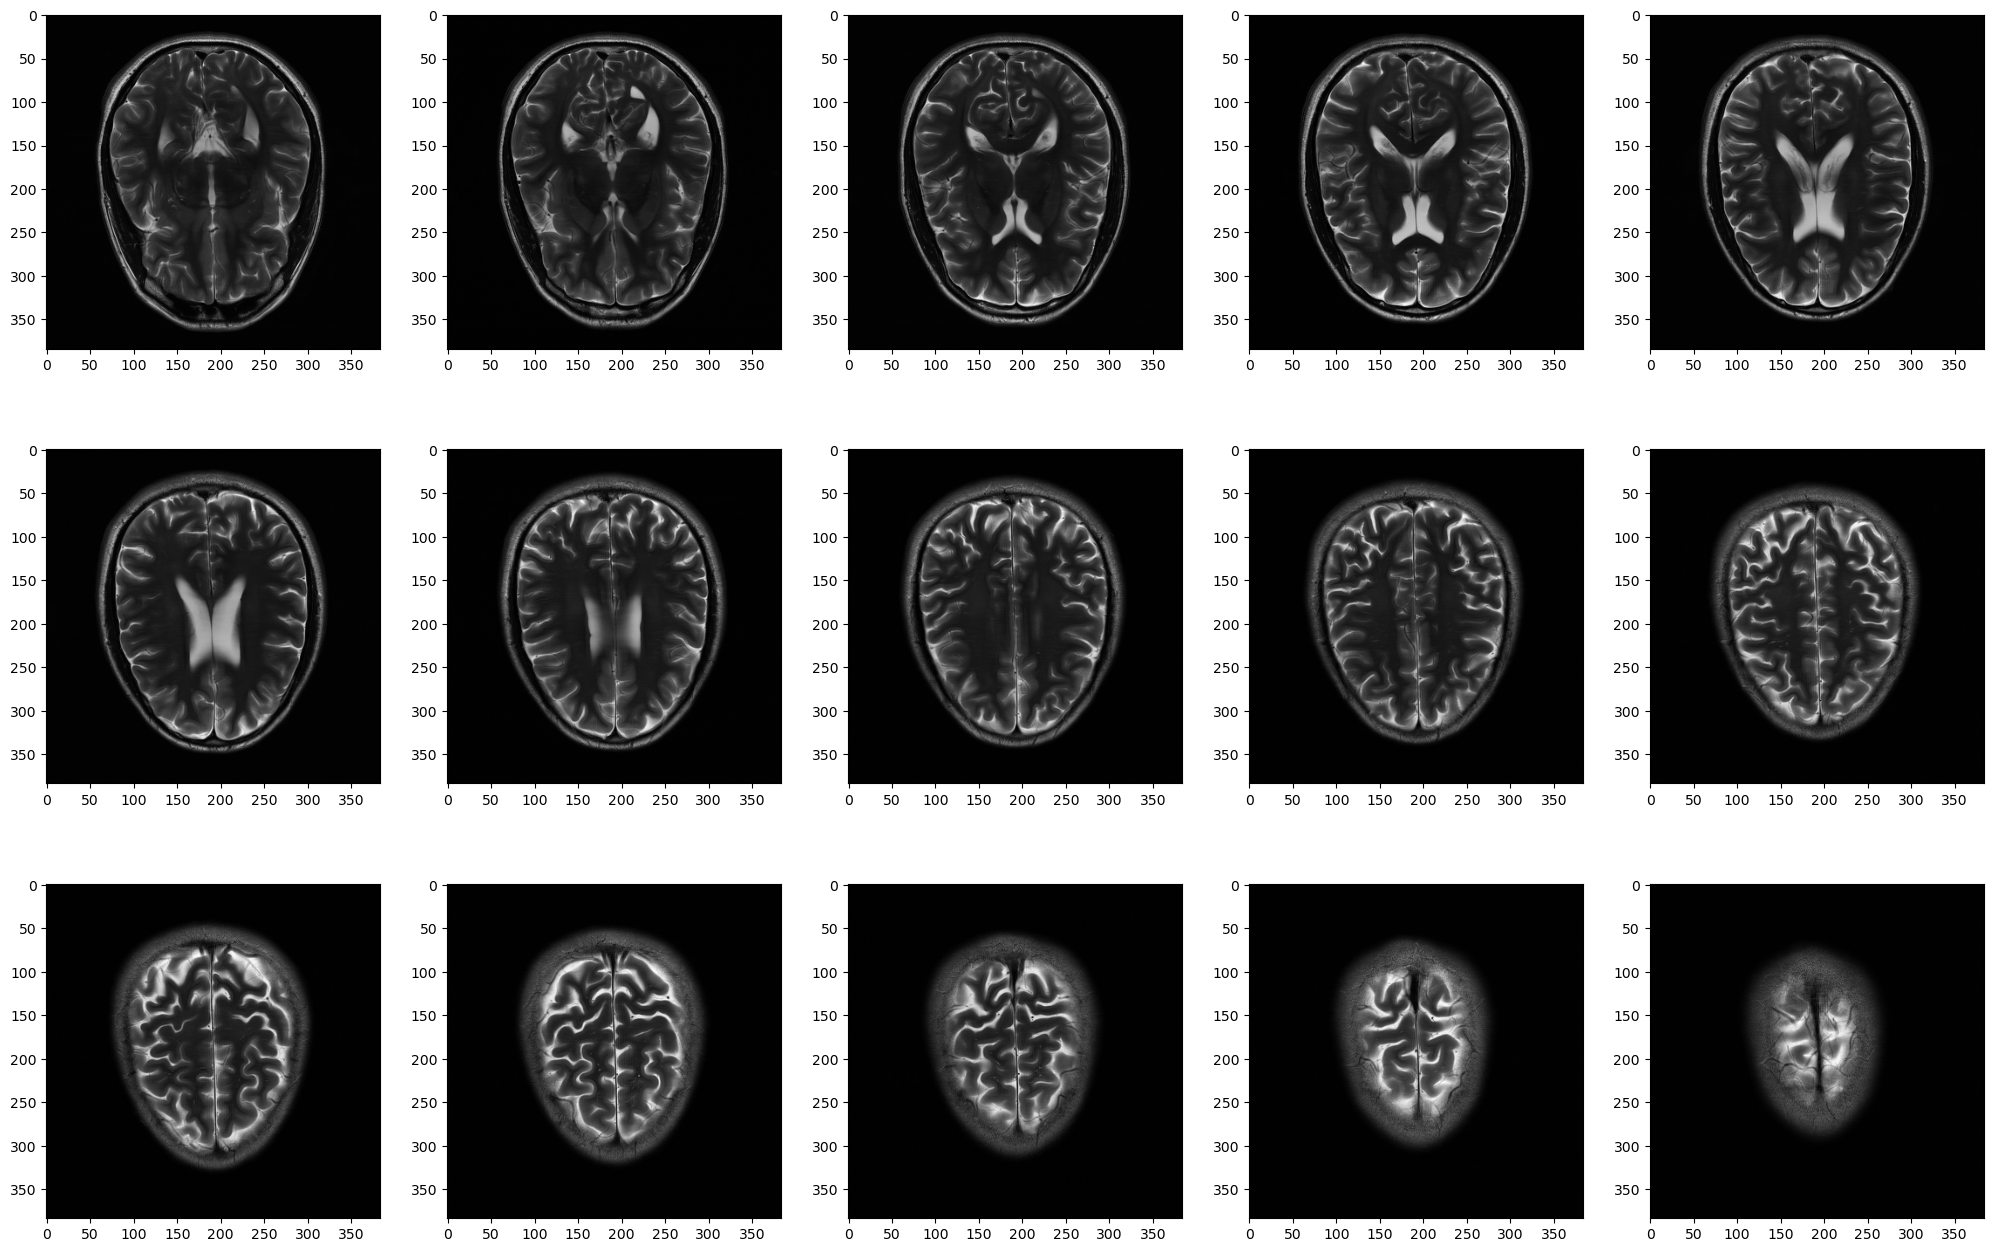

In [114]:
plt.rcParams['figure.figsize'] = [25, 16] # enlarge inline plots

show_slices(volume_reconstruction, 15, cmap='gray')

# fig = plt.figure()
# plt.imshow(slice_reconstruction, cmap='gray')

## Unet

```
python fastMRI/fastmri_examples/unet/run_pretrained_unet_inference.py \
    --data_path /media/drazen/HDD/PC/Faks/Diplomski/Prva/OSIRV/Projekt/datasets/multicoil_test \
    --output_path /media/drazen/HDD/PC/Faks/Diplomski/Prva/OSIRV/Projekt/datasets/out_unet \
    --challenge unet_brain_mc
```




In [101]:
file_name = '/media/drazen/HDD/PC/Faks/Diplomski/Prva/OSIRV/Projekt/datasets/out_unet/reconstructions/file_brain_AXT2_201_2010573.h5'
hf = h5py.File(file_name)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/media/drazen/HDD/PC/Faks/Diplomski/Prva/OSIRV/Projekt/datasets/out_unet/reconstructions/file_brain_AXT2_201_2010573.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['reconstruction']
Attrs: {}


We don't have `kspace` key anymore, now we have to use `reconstruction` key.

`Reconstruction` volume has the following shape: (number of slices, height, width).

In [ ]:
volume_reconstruction = hf['reconstruction'][()]
print(volume_reconstruction.dtype)
print(volume_reconstruction.shape)

float32
(16, 384, 384)


In [ ]:
slice_reconstruction = volume_reconstruction[10] # Choosing the 10th slice
print(slice_reconstruction.shape)

(384, 384)


In [ ]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

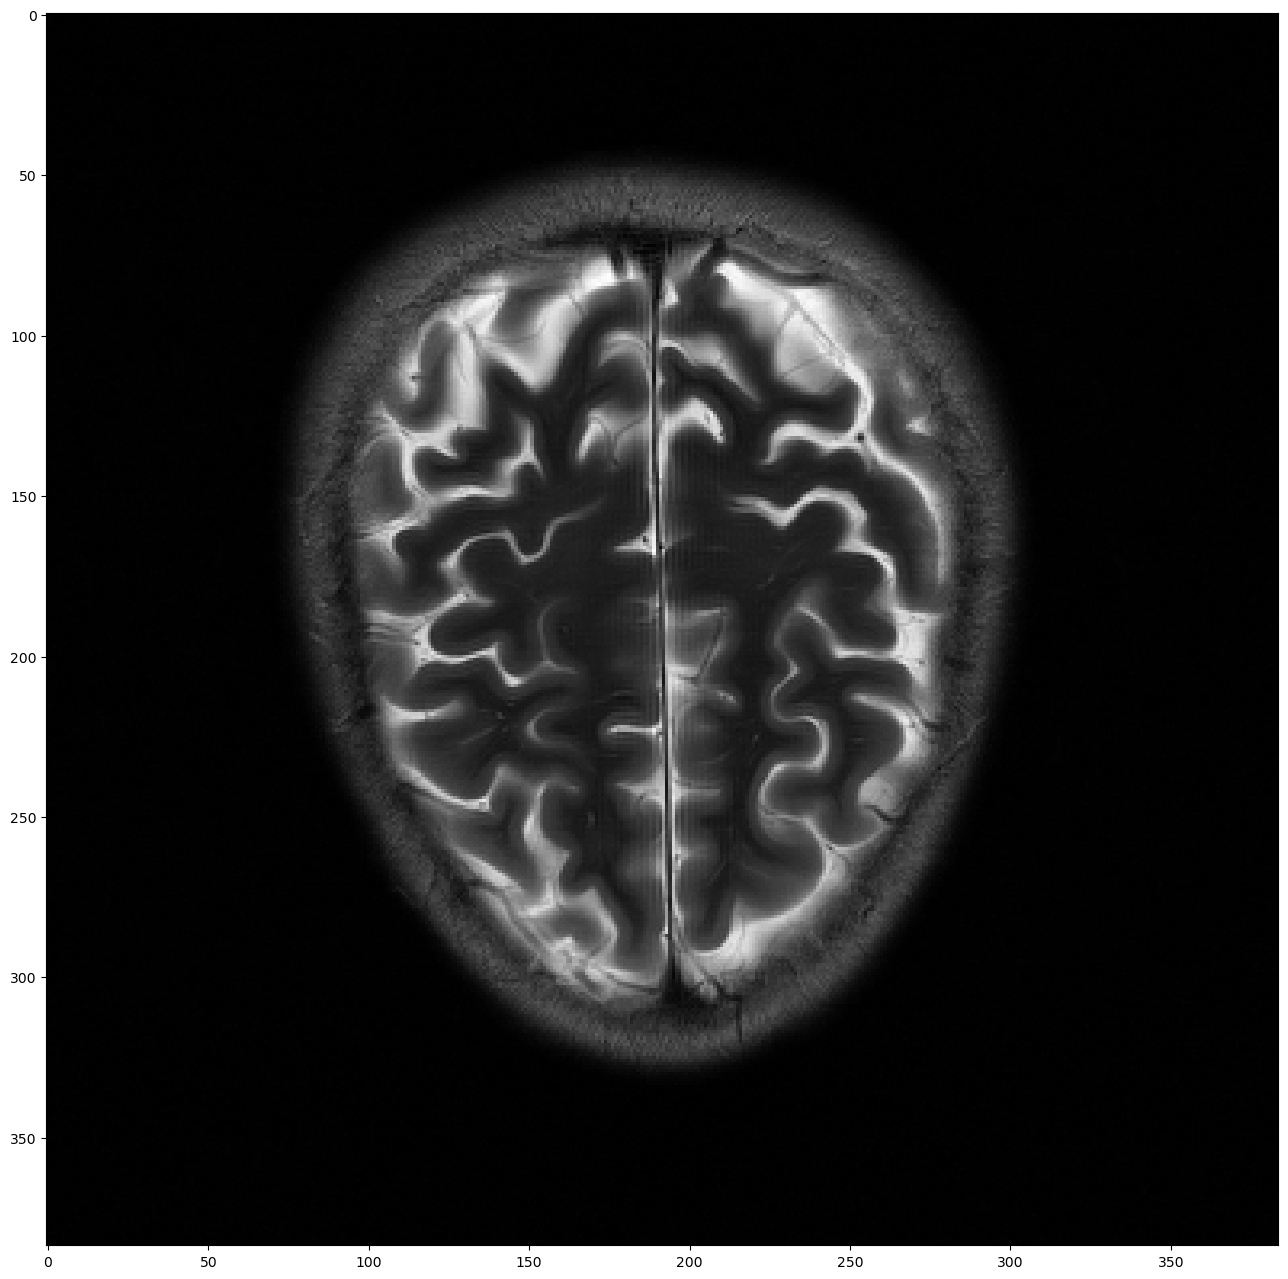

In [ ]:
plt.rcParams['figure.figsize'] = [20, 16] # enlarge inline plots

fig = plt.figure()
plt.imshow(slice_reconstruction, cmap='gray')